# Perterbation Testing

To verify that my environment and morphology representation have continuous loss slope (and is therefore amenable to gradient descent),
I took existing pre-designed morphologies and randomly mutated one of the parameters (in this case, just one of the joint parameters).
The performance of the mutated morphology was compared to the original, and then the mutated parameter was permuted up and down by a small amount, and re-evaluated. 
The best performing permutation was kept and the other discarded. This permutation process was repeated 5 times in total, such that the permuted 'children' of 
the original mutated morphology were >= the first permutation's performance. The expectation was to see that bad mutations moved back towards the shape of the original.

This is a graph of how the mutated parameter changed over time.

In [1]:
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Import the Data

In [2]:
data_dir = "../models/permutation_testing"

df = pd.DataFrame(columns=["hand", "task"] + [f"val_{i}" for i in range(6)] + [f"perf_{i}" for i in range(6)])

for idx, dir in enumerate(os.listdir(data_dir)):
    path = os.path.join(data_dir, dir)
    if not os.path.isdir(path):
        continue

    results = open(os.path.join(path, "results.txt"), "r")
    lines = results.readlines()
    results.close()

    # Find hand and task type
    hand_type = re.search(r"hand type: (\d+)", lines[0])[1]
    task_type = re.search(r"task type: (\d+)", lines[0])[1]
    df.loc[idx, "hand"] = hand_type
    df.loc[idx, "task"] = task_type

    # Find parameter values
    original = re.findall(r"([-\d\.]+)", lines[11])[1]
    vals = [re.findall(r"([-\d\.]+)", line)[3] for line in lines[5:10]]
    df.loc[idx, "val_0"] = original
    for i, val in enumerate(vals):
        df.loc[idx, f"val_{i + 1}"] = val

    # Find performance values
    original = re.findall(r"([-\d\.]+)", lines[2])[0]
    vals = [re.findall(r"([-\d\.]+)", line)[1] for line in lines[5:10]]
    df.loc[idx, "perf_0"] = original
    for i, val in enumerate(vals):
        df.loc[idx, f"perf_{i + 1}"] = val

In [3]:
# Convert cols to numbers
for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col])

## Graph the Values over Generations

In [4]:
# Normalize the performance and values
df.iloc[:, 2:8] = df.iloc[:, 2:8].apply(lambda x: x - x.iloc[0], axis=1)
df.iloc[:, 8:] = df.iloc[:, 8:].apply(lambda x: x - x.iloc[0], axis=1)
val_std = df.iloc[:, 2:8].std(axis=1)
perf_std = df.iloc[:, 8:].std(axis=1)
df.iloc[:, 2:8] = df.iloc[:, 2:8].div(val_std, axis=0)
df.iloc[:, 8:] = df.iloc[:, 8:].div(perf_std, axis=0)

# Melt the DataFrame for easier plotting
val_columns = [col for col in df.columns if col.startswith('val_')][1:] + ["hand", "task"]
df_vals_long = df[val_columns].reset_index().melt(id_vars=['index', 'hand', 'task'], var_name='x', value_name='y')
df_vals_long['x'] = df_vals_long['x'].str.extract(r'val_(\d+)').astype(int)

perf_columns = [col for col in df.columns if col.startswith('perf_')][1:] + ["hand", "task"]
df_perf_long = df[perf_columns].reset_index().melt(id_vars=['index', 'hand', 'task'], var_name='x', value_name='y')
df_perf_long['x'] = df_perf_long['x'].str.extract(r'perf_(\d+)').astype(int)

df_vals_long = df_vals_long.rename(columns={'index': 'line_id'})
df_perf_long = df_perf_long.rename(columns={'index': 'line_id'})

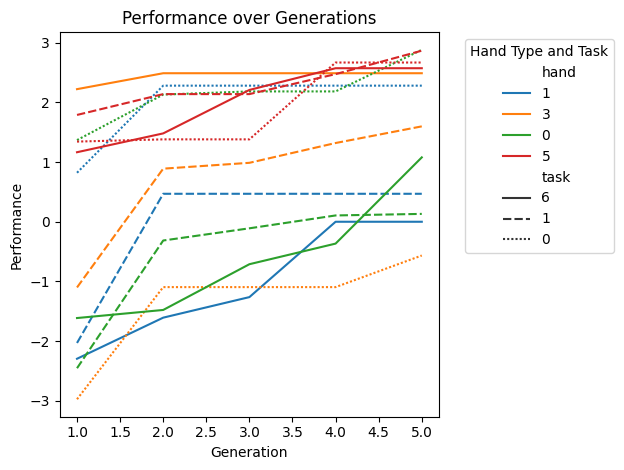

In [5]:
sns.lineplot(data=df_perf_long, x='x', y='y', hue='hand', style='task')
plt.xlabel("Generation")
plt.ylabel("Performance")
plt.title("Performance over Generations")
plt.legend(title="Hand Type and Task", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../diagrams/permutation_test_perf.png")
plt.show()

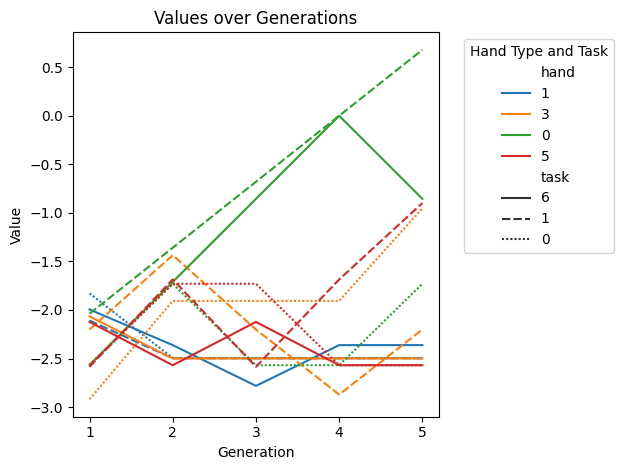

In [6]:
sns.lineplot(data=df_vals_long, x='x', y='y', hue='hand', style='task')
plt.xlabel("Generation")
plt.ylabel("Value")
plt.title("Values over Generations")
plt.legend(title="Hand Type and Task", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../diagrams/permutation_test_vals.png")
plt.show()